# **Simple Autoencoder**
Inspired from: https://medium.com/red-buffer/autoencoders-guide-and-code-in-tensorflow-2-0-a4101571ce56

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

fashion = tf.keras.datasets.fashion_mnist
(fx_train, fy_train), (fx_test, fy_test) = fashion.load_data()

fx_train = tf.keras.utils.normalize(fx_train, axis=1)
fx_test = tf.keras.utils.normalize(fx_test, axis=1)

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
class FullyConnectedAutoEncoder(tf.keras.Model):
    def __init__(self):
        super(FullyConnectedAutoEncoder, self).__init__()
        self.flatten_layer = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(64)
        #self.dense2 = tf.keras.layers.Dense(32, activation=tf.nn.relu)
        
        
        self.bottleneck = tf.keras.layers.Dense(32)
    
        #self.dense4 = tf.keras.layers.Dense(32, activation=tf.nn.relu)
        self.dense5 = tf.keras.layers.Dense(64)
        
        self.dense_final = tf.keras.layers.Dense(784, activation=tf.nn.sigmoid)
        
    
    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        #x = self.dense2(x)
        x = self.bottleneck(x)
        #x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped

In [0]:
def loss(x, x_bar):
    return tf.losses.binary_crossentropy(x, x_bar)
def grad(model, inputs):
    with tf.GradientTape() as tape:
        reconstruction, inputs_reshaped = model(inputs)
        loss_value = loss(inputs_reshaped, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), inputs_reshaped, reconstruction

In [8]:
model = FullyConnectedAutoEncoder()
optimizer = tf.optimizers.Adam(learning_rate=0.001)
global_step = tf.Variable(0)
num_epochs = 10
batch_size = 256
for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    for x in range(0, len(fx_train), batch_size):
        x_inp = fx_train[x : x + batch_size]
        loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables),
                              global_step)
        
    if global_step.numpy() % 500 == 0:
        print("Step: {}, Loss: {}".format(global_step.numpy(),loss(inputs_reshaped, reconstruction).numpy()))
    #print("Step: {},         Loss: {}".format(global_step.numpy(),loss(inputs_reshaped, reconstruction).numpy()))

Epoch:  0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0,         Loss: [0.35763106 0.41841173 0.28868386 0.30612436 0.314783   0.22597931
 0.2149804  0.26130253 0.31176198 0.34140483 0.17535433 0.1905077
 0.27242118 0.2802289  0.2004276  0.33633915 0.25545618 0.34702852
 0.36112875 0.41943946 0.3268486  0.16526599 0.3472731  0.18544412
 0.2586524  0.41524425 0.30972585 0.17377459 0.22992484 0.29935002
 0.27780062 0.23095037 0.18407677 0.35462493 0.17987177 0.27361274
 0.1884683  0.29220793 0.4000576  0.2953685  0.3280533  0.32655504
 0.1865

In [0]:
predictions = model.predict(fx_test)

In [0]:
import numpy as np
array = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
#print(array[np.argmax(predictions[67])])

Dress


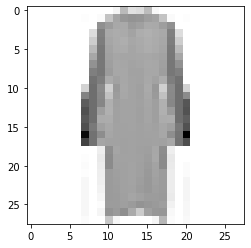

In [11]:
plt.imshow(fx_test[67], cmap=plt.cm.binary)
print(array[fy_test[67]])
plt.show()

# **Convolutional Autoencoder**

In [0]:
fx_train = tf.reshape(fx_train, (len(fx_train), 28, 28, 1))
fx_test = tf.reshape(fx_test, (len(fx_test), 28, 28, 1))

In [0]:
class ConvNetAutoEncoder(tf.keras.Model):
    def __init__(self):
        super(ConvNetAutoEncoder, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')
        self.maxp1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')
        self.maxp2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
        self.conv3 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')
        
        self.encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
        
        self.conv4 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')
        self.upsample1 = tf.keras.layers.UpSampling2D((2, 2))
        self.conv5 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')
        self.upsample2 = tf.keras.layers.UpSampling2D((2, 2))
        self.conv6 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
        self.upsample3 = tf.keras.layers.UpSampling2D((2, 2))
        self.conv7 = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        
    
    def call(self, x):
        x = self.conv1(x)
        x = self.maxp1(x)
        x = self.conv2(x)
        x = self.maxp2(x)
        x = self.conv3(x)
        x = self.encoded(x)
        x = self.conv4(x)
        x = self.upsample1(x)
        x = self.conv5(x)
        x = self.upsample2(x)
        x = self.conv6(x)
        x = self.upsample3(x)
        x = self.conv7(x)
        return x
def loss(x, x_bar):
    return tf.losses.mean_squared_error(x, x_bar)
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        reconstruction = model(inputs)
        loss_value = loss(targets, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), reconstruction

In [14]:
model = ConvNetAutoEncoder()
optimizer = tf.optimizers.Adam(learning_rate=0.001)
global_step = tf.Variable(0)
num_epochs = 5
batch_size = 4
for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    for x in range(0, len(fx_train), batch_size):
        x_inp = fx_train[x : x + batch_size]
        loss_value, grads, reconstruction = grad(model, x_inp, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables),
                              global_step)
        
    if global_step.numpy() % 100000 == 0:
        print("Step: {},         Loss: {}".format(global_step.numpy(),
                                      loss(x_inp, reconstruction).numpy()))

Epoch:  0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0,         Loss: [[[9.66248696e-12 3.18683017e-16 1.14137782e-16 ... 1.42316848e-16
   3.39789331e-16 8.08777142e-11]
  [5.47184078e-16 2.93431392e-22 7.74265969e-23 ... 8.96798029e-23
   2.74353504e-22 1.42863643e-14]
  [7.40092589e-17 1.76491030e-23 4.15552124e-24 ... 4.76532847e-24
   1.57088791e-23 2.08371016e-15]
  ...
  [1.42544180e-13 6.57172404e-19 1.18657611e-19 ... 7.84035128e-24
   3.91235503e-23 1.46146726e-14]
  [4.07092681e-13 2.68756234e-18 5.01528187e-19 ... 6.75231361e-2